In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Requirements

- DIY regression algorithm
- Compare results with scikit-learn implementation
- Train and test with different dataset partitions, compare errors
- Validate and compare different models and/or parameter sets
- Feature engineering (various feature combinations, polynomial features, etc)
- Interpret results

# Preparation

Data source: https://www.kaggle.com/ueslei/ucs-satellite-database

In [2]:
df = pd.read_csv('../2_EDA/ucs-satellite-database/UCS_Satellite_Database_12-1-2018-1.csv',
    engine='python', decimal=',', thousands='.', parse_dates=['Date of Launch'], dayfirst=True)

# Remove some columns
df.drop(df.columns[df.columns.tolist().index('Comments')+1:], axis=1, inplace=True)

# Type conversions
df['Eccentricity'] = df['Eccentricity'].replace(',', '.', regex=True).astype(float)
df['Inclination (degrees)'] = df['Inclination (degrees)'].replace(',', '.', regex=True).astype(float)

In [3]:
df.head()

,"Name of Satellite, Alternate Names",Country/Org of UN Registry,Country of Operator/Owner,Operator/Owner,Users,Purpose,Detailed Purpose,Class of Orbit,Type of Orbit,Longitude of GEO (degrees),...,Power (watts),Date of Launch,Expected Lifetime (yrs.),Contractor,Country of Contractor,Launch Site,Launch Vehicle,COSPAR Number,NORAD Number,Comments
0,3Cat-1,NR (11/18),Spain,Universitat Polit�cnica de Catalunya,Civil,Technology Development,NaN,LEO,NaN,0.0,...,NaN,2018-11-29,NaN,Universitat Polit�cnica de Catalunya,Spain,Satish Dhawan Space Centre,PSLV,2018-096,43723,Student built.
1,Aalto-1,Finland,Finland,University of Aalto,Civil,Technology Development,NaN,LEO,NaN,0.0,...,4.5,2017-06-23,2,University of Aalto,Finland,Satish Dhawan Space Centre,PSLV,2017-036L,42775,Technology development and education.
2,AAUSat-4,Denmark,Denmark,University of Aalborg,Civil,Earth Observation,Automatic Identification System (AIS),LEO,Sun-Synchronous,0.0,...,NaN,2016-04-25,NaN,University of Aalborg,Denmark,Guiana Space Center,Soyuz 2.1a,2016-025E,41460,Carries AIS system.
3,"ABS-2 (Koreasat-8, ST-3)",NR,Multinational,Asia Broadcast Satellite Ltd.,Commercial,Communications,NaN,GEO,NaN,75.0,...,16,2014-02-06,15,Space Systems/Loral,USA,Guiana Space Center,Ariane 5 ECA,2014-006A,39508,"32 C-band, 51 Ku-band, and 6 Ka-band transpond..."
4,ABS-2A,NR (12/16),Multinational,Asia Broadcast Satellite Ltd.,Commercial,Communications,NaN,GEO,NaN,-75.0,...,NaN,2016-06-15,15,Boeing Satellite Systems,USA,Cape Canaveral,Falcon 9,2016-038A,41588,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1957 entries, 0 to 1956
Data columns (total 27 columns):
Name of Satellite, Alternate Names    1957 non-null object
Country/Org of UN Registry            1957 non-null object
Country of Operator/Owner             1957 non-null object
Operator/Owner                        1957 non-null object
Users                                 1957 non-null object
Purpose                               1957 non-null object
Detailed Purpose                      720 non-null object
Class of Orbit                        1955 non-null object
Type of Orbit                         1348 non-null object
Longitude of GEO (degrees)            1956 non-null object
Perigee (km)                          1957 non-null float64
Apogee (km)                           1957 non-null int64
Eccentricity                          1957 non-null float64
Inclination (degrees)                 1957 non-null float64
Period (minutes)                      1957 non-null float64
Launch

In [5]:
df['Inclination (degrees)']

0       97.40
1       97.45
2       98.20
3        0.08
4        0.00
        ...  
1952    97.40
1953    97.46
1954    98.56
1955    97.50
1956    97.50
Name: Inclination (degrees), Length: 1957, dtype: float64

## Outliers

In [6]:
def outliers_iqr(df, feature):
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1
    outliers = ((df[[feature]] < (q1 - 1.5 * iqr)) |(df[[feature]] > (q3 + 1.5 * iqr))).any(axis=1)
    return outliers

## Evaluation metrics
- MAE: mean absolute error
- MSE: mean squared error
- RMSE: root mean squared error
- R2: coefficient of determination

In [7]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

def print_metrics(y_true, y_pred):
    print(f'MAE: {mean_absolute_error(y_true, y_pred)}')
    print(f'MSE: {mean_squared_error(y_true, y_pred)}')
    print(f'RMSE: {np.sqrt(mean_squared_error(y_true, y_pred))}')
    print(f'R2: {r2_score(y_true, y_pred)}')

# Simple linear regression
Let's try to predict satellite's orbital period using apogee values

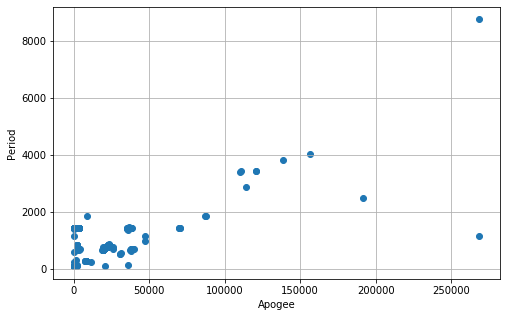

In [8]:
# With outliers
plt.figure(figsize=(8, 5))
plt.scatter(df['Apogee (km)'], df['Period (minutes)'])
plt.xlabel('Apogee')
plt.ylabel('Period')
plt.grid()
plt.show()

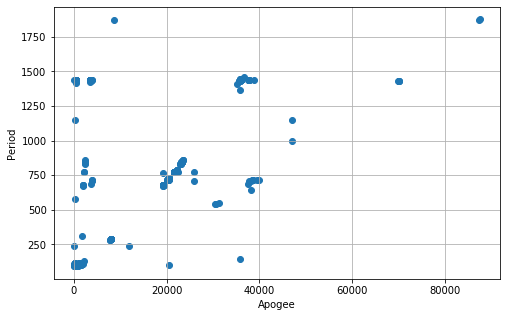

In [9]:
# Without outliers
non_outliers = ~outliers_iqr(df, 'Apogee (km)')

plt.figure(figsize=(8, 5))
plt.scatter(df[non_outliers]['Apogee (km)'], df[non_outliers]['Period (minutes)'])
plt.xlabel('Apogee')
plt.ylabel('Period')
plt.grid()
plt.show()

In [10]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
X = df[non_outliers]['Apogee (km)'].values.reshape(-1, 1)
y = df[non_outliers]['Period (minutes)'].values.reshape(-1, 1)
lr.fit(X, y)
y_pred = lr.predict(X)

print('Training error:')
print_metrics(y, lr.predict(X))

print()
print('Model parameters:')
print(lr.coef_, lr.intercept_)

Training error:
MAE: 113.56576369066704
MSE: 60367.282909143425
RMSE: 245.697543555371
R2: 0.8333222573049205

Model parameters:
[[0.03449188]] [137.70262186]


## Train/test split

In [11]:
from sklearn.model_selection import train_test_split

# Default proportions are 75% / 25%
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100)
lr.fit(X_train, y_train)
# y_pred = lr.predict(X_test)

print('Training error:')
print_metrics(y_train, lr.predict(X_train))

print()
print('Test error:')
print_metrics(y_test, lr.predict(X_test))

Training error:
MAE: 116.56074313703282
MSE: 62036.68255500926
RMSE: 249.07164141067778
R2: 0.8313641843424914

Test error:
MAE: 112.19168654130539
MSE: 55383.01263889283
RMSE: 235.33595696130422
R2: 0.8382992655375505


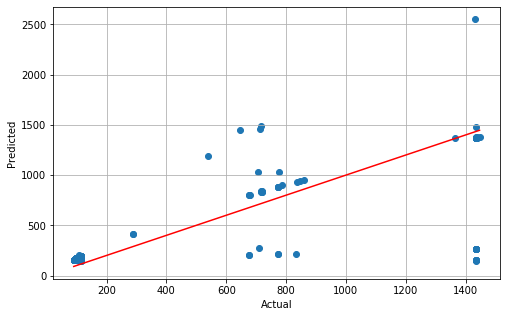

In [12]:
# Actual vs. predicted values:
def plot_true_vs_pred(y_true, y_pred):
    plt.figure(figsize=(8, 5))
    plt.scatter(y_true, y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.grid()
    plt.show()
    
plot_true_vs_pred(y_test, lr.predict(X_test))

# Multiple linear regression
Using more features:

In [13]:
mlr_features = ['Perigee (km)', 'Apogee (km)', 'Eccentricity', 'Inclination (degrees)']

X = df[non_outliers][mlr_features].values
y = df[non_outliers]['Period (minutes)'].values.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=99)

Training error:
MAE: 88.93722331809948
MSE: 27936.489759789732
RMSE: 167.14212443244142
R2: 0.923603439111813

Test error:
MAE: 86.67793658056634
MSE: 28510.53400875772
RMSE: 168.8506263203004
R2: 0.9188295320575284


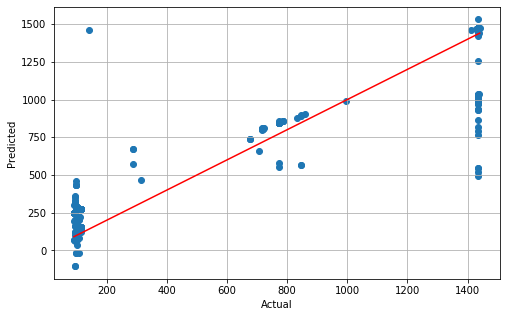

In [14]:
mlr = LinearRegression()
mlr.fit(X_train, y_train)

print('Training error:')
print_metrics(y_train, mlr.predict(X_train))
print()
print('Test error:')
print_metrics(y_test, mlr.predict(X_test))

plot_true_vs_pred(y_test, mlr.predict(X_test))

# Model selection

## Feature engineering

Training error:
MAE: 40.48996297169756
MSE: 15077.134886523574
RMSE: 122.78898520031662
R2: 0.9587692919446307

Test error:
MAE: 39.42122541884381
MSE: 19006.358982335936
RMSE: 137.863552044534
R2: 0.9458882442536884


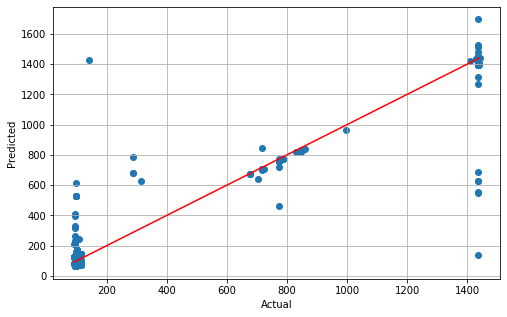

In [15]:
from sklearn.preprocessing import PolynomialFeatures

# Polynomial features: 2nd degree
poly2 = PolynomialFeatures(degree=2)
X_train_p2 = poly2.fit_transform(X_train)
X_test_p2 = poly2.fit_transform(X_test)

mlr2 = LinearRegression(normalize=True)
mlr2.fit(X_train_p2, y_train)

print('Training error:')
print_metrics(y_train, mlr2.predict(X_train_p2))
print()
print('Test error:')
print_metrics(y_test, mlr2.predict(X_test_p2))

plot_true_vs_pred(y_test, mlr2.predict(X_test_p2))

Training error:
MAE: 31.737717827034476
MSE: 8660.623654756519
RMSE: 93.06247178512142
R2: 0.9763162133804437

Test error:
MAE: 49.492969713895384
MSE: 50721.31338630205
RMSE: 225.21392804687292
R2: 0.8555946815672332


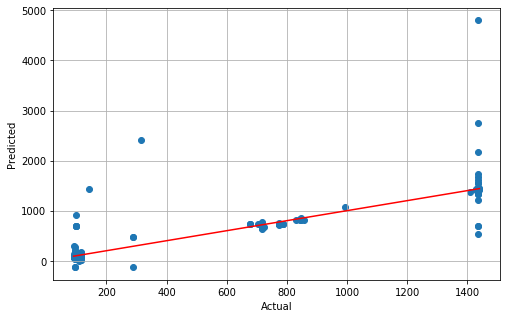

In [16]:
# Polynomial features: 3rd degree
poly3 = PolynomialFeatures(degree=3)
X_train_p3 = poly3.fit_transform(X_train)
X_test_p3 = poly3.fit_transform(X_test)

mlr3 = LinearRegression(normalize=True)
mlr3.fit(X_train_p3, y_train)

print('Training error:')
print_metrics(y_train, mlr3.predict(X_train_p3))
print()
print('Test error:')
print_metrics(y_test, mlr3.predict(X_test_p3))

plot_true_vs_pred(y_test, mlr3.predict(X_test_p3))

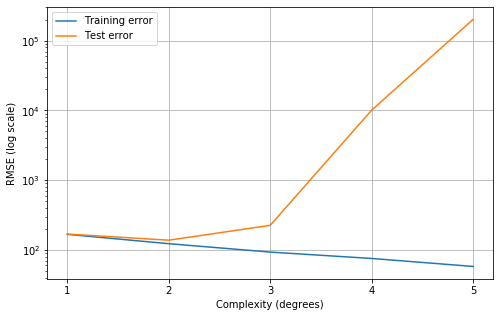

In [17]:
train_errors, test_errors = [], []
degrees = list(range(1, 6))

for deg in degrees:
    poly = PolynomialFeatures(degree=deg)
    X_train_p = poly.fit_transform(X_train)
    X_test_p = poly.fit_transform(X_test)

    mlrp = LinearRegression(normalize=True)
    mlrp.fit(X_train_p, y_train)
    
    # RMSE
    train_error = np.sqrt(mean_squared_error(y_train, mlrp.predict(X_train_p)))
    test_error = np.sqrt(mean_squared_error(y_test, mlrp.predict(X_test_p)))
    train_errors.append(train_error)
    test_errors.append(test_error)
    
plt.figure(figsize=(8, 5))
plt.plot(train_errors, label='Training error')
plt.plot(test_errors, label='Test error')
plt.xticks(range(0, 5), degrees)
plt.xlabel('Complexity (degrees)')
plt.ylabel('RMSE (log scale)')
plt.legend()
plt.yscale('log')
plt.grid()
plt.show()

## Regularization

/home/tomas/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7825667.420132825, tolerance: 53388.88894355954
  positive)
/home/tomas/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7825679.229031531, tolerance: 53388.88894355954
  positive)
/home/tomas/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 7825797.314858199, tolerance: 53388.88894355954
  positive)
/home/tomas/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not 

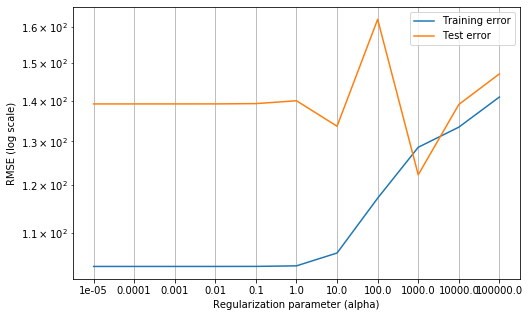

In [18]:
from sklearn.linear_model import Lasso

train_errors, test_errors = [], []
alphas = np.geomspace(1e-5, 1e5, 11)

# Using 3rd degree polynomial features
for alpha in alphas:
    rr = Lasso(alpha=alpha)
    rr.fit(X_train_p3, y_train)
    
    # RMSE
    train_error = np.sqrt(mean_squared_error(y_train, rr.predict(X_train_p3)))
    test_error = np.sqrt(mean_squared_error(y_test, rr.predict(X_test_p3)))
    train_errors.append(train_error)
    test_errors.append(test_error)
    
plt.figure(figsize=(8, 5))
plt.plot(train_errors, label='Training error')
plt.plot(test_errors, label='Test error')
plt.xticks(range(0, len(alphas)), alphas)
plt.xlabel('Regularization parameter (alpha)')
plt.ylabel('RMSE (log scale)')
plt.legend()
plt.yscale('log')
plt.grid()
plt.show()

/home/tomas/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12464022.406669173, tolerance: 53388.88894355954
  positive)


Training error:
MAE: 39.91559217124188
MSE: 16544.22131290706
RMSE: 128.62434183663316
R2: 0.9547573219918859

Test error:
MAE: 35.64593701108792
MSE: 14966.172253974677
RMSE: 122.33630799551977
R2: 0.9573907944063903


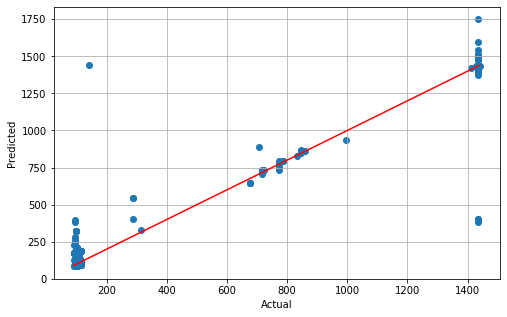

In [19]:
# Check with particular alpha value:
rr1 = Lasso(alpha=1000)
rr1.fit(X_train_p3, y_train)

print('Training error:')
print_metrics(y_train, rr1.predict(X_train_p3))
print()
print('Test error:')
print_metrics(y_test, rr1.predict(X_test_p3))

plot_true_vs_pred(y_test, rr1.predict(X_test_p3))

## Detecting outliers from residuals

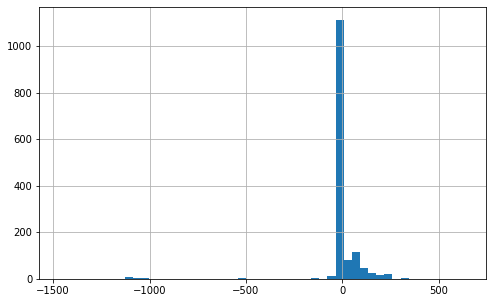

In [20]:
diffs = rr1.predict(X_train_p3) - y_train.reshape(-1)

plt.figure(figsize=(8, 5))
plt.hist(diffs, bins=50)
plt.grid()
plt.show()

In [21]:
# Remove outliers from training set
mask = diffs > -500
X_train_p3_sub = X_train_p3[mask]
y_train_sub = y_train[mask]

/home/tomas/.pyenv/versions/3.7.2/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 720822.4020900116, tolerance: 52024.02143070323
  positive)


Training error:
MAE: 6.204437229474805
MSE: 642.4141351574525
RMSE: 25.345889906599304
R2: 0.9982205935963736

Test error:
MAE: 20.293096343793735
MSE: 17728.780135384804
RMSE: 133.1494653965415
R2: 0.949525555038838


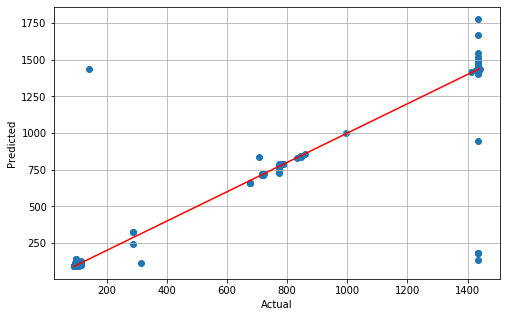

In [22]:
# Re-train the model
rr2 = Lasso(alpha=1000)
rr2.fit(X_train_p3_sub, y_train_sub)

print('Training error:')
print_metrics(y_train_sub, rr2.predict(X_train_p3_sub))
print()
print('Test error:')
print_metrics(y_test, rr2.predict(X_test_p3))

plot_true_vs_pred(y_test, rr2.predict(X_test_p3))

## Feature importance

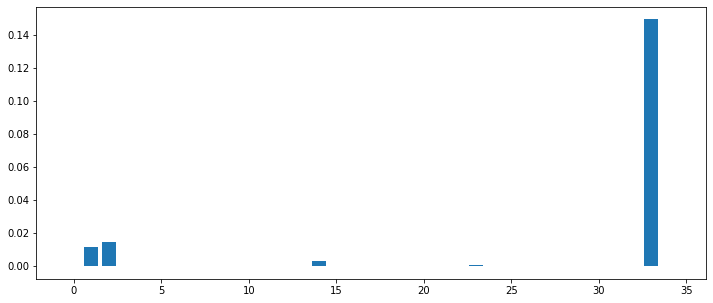

[ 0.00000000e+00  1.14914599e-02  1.43356652e-02  0.00000000e+00
  0.00000000e+00  4.87273004e-07 -5.26338999e-07  0.00000000e+00
 -2.31906644e-04  5.78129229e-07  0.00000000e+00  1.05340794e-04
  0.00000000e+00  0.00000000e+00  2.63549686e-03  8.10723036e-12
 -1.53079509e-11  5.73903548e-07  8.45474999e-09 -1.12429263e-12
 -4.60372640e-07 -1.12219827e-08  0.00000000e+00  5.27259030e-04
  2.89932503e-06  2.63584169e-12 -8.92814212e-07  6.00132086e-09
  1.41139653e-06 -4.48955172e-04 -2.84861915e-06 -4.88074093e-07
  0.00000000e+00  1.49204337e-01 -2.50555901e-05]
0.14920433653997997
[0 0 1 2]


In [23]:
plt.figure(figsize=(12, 5))
plt.bar(range(len(rr2.coef_)), rr2.coef_)
plt.show()

print(rr2.coef_)
print(rr2.coef_[-2])
print(poly3.powers_[-2])